# Spectral denoising as feature engineering

In this notebook we investigate the use of Fourier and Wavelet tranforms as a denosing pre-processing step prior to time series forecasting. This approach can be summarised as:
- step 1: Spectral tranforms of time series data, a transform from the time to frequency domain
- step 2: filter out high frequency noise components.
- step 3: inverses tranforms the frequency signal back to the time domain.
- step 4: forecasting the denoised signal. 

In [2]:
# import my bespoke modules
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2
from spectral_denoising import automatic_fourier_denoising, automatic_fourier_denoising_wf

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

# general data wrangling and visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tabulate import tabulate



2022-05-13 14:04:09.752370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 14:04:09.752405: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Fourier methods

In [ ]:
financial_assets = ['CrudeOil']#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_fourier'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:-split]) # data
    denoised_signal = automatic_fourier_denoising(signal,df, split)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=False,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10,
                                                                                    transformer=automatic_fourier_denoising_wf,
                                                                                    only_training=True)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')



# 2. Wavelet methods

maximum level is 7


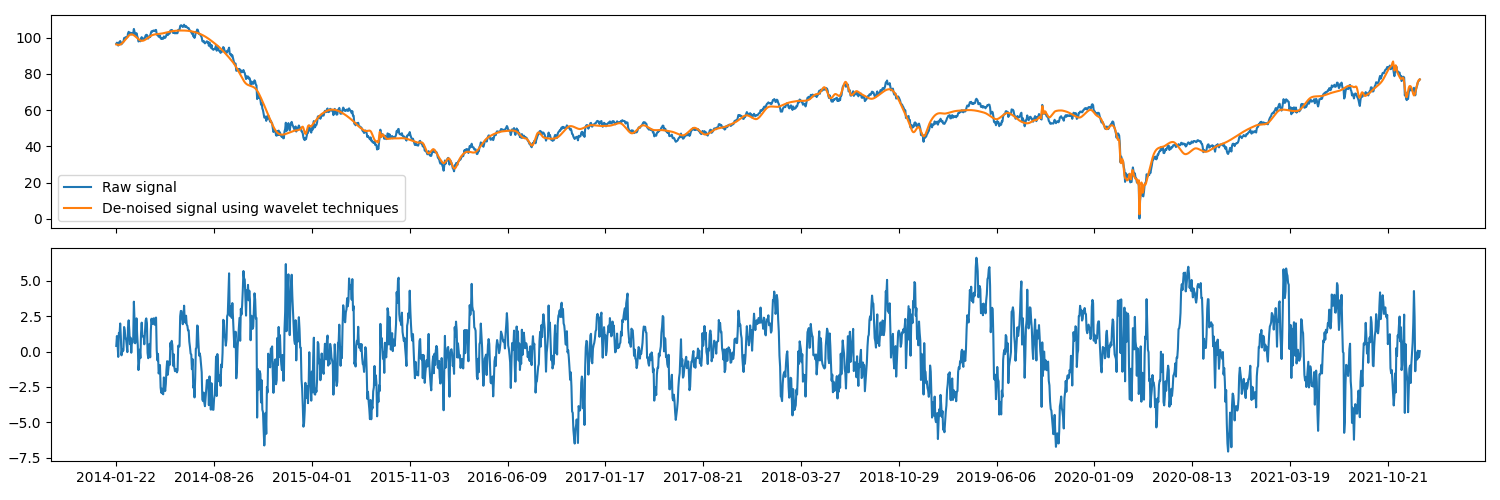

In [23]:
import pywt

# Time series / data:
financial_asset = 'CrudeOil'
feat_engineering = 'test_wavelet'
column_to_predict = 'Close' #'#Passengers' 

df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days

signal = df['Close'].to_numpy()

# Create wavelet object and define parameters
w = pywt.Wavelet('sym8') # sym family look good too sym8, this is where you should change the wavelet type, haar wavelet is simply 'haar'
maxlev = pywt.dwt_max_level(len(signal), w.dec_len)
print("maximum level is " + str(maxlev))
threshold = 0.5 # Threshold for filtering coefficients as part of denoising, the higher this value the more coefficients you set to zero, ie more of the original signal you truncate away / denoise

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(signal, w, level=maxlev) # multi-level decomposition

# Threshold the wavelet coefficients, thereby removing noise

# plt.figure(figsize=(8,15))
for i in range(1, len(coeffs)):
    # plt.subplot(maxlev, 1, i)
    # plt.plot(coeffs[i],label='Original coefficients')
    coeffs[i] = pywt.threshold(coeffs[i], threshold*np.max(coeffs[i]),mode='hard')
    # plt.plot(coeffs[i],label='Thresholded coefficients')
    # plt.ylabel('Scale: '+str(maxlev-i+1))
    # plt.legend()
    plt.tight_layout()

# inverse transform coefficient to reconstruct time series signal, minus noise
datarec = pywt.waverec(coeffs, w) # multi-level decomposition reconstruction

fig, ax = plt.subplots(2,1,figsize=(15,5),sharex=True)
ax[0].plot(df['Date'], signal,label='Raw signal')
ax[0].plot(df['Date'], datarec,label="De-noised signal using wavelet techniques")

ax[1].plot(df['Date'], signal-datarec,label="Noise component")

max = df.shape[0]
ax[1].set_xticks([df['Date'].iloc[x] for x in range(0,max,150)])
ax[0].legend()
plt.tight_layout()
plt.show()

# Distance measures between true signal and denoised


maximum level is 7


0.01077526366430583

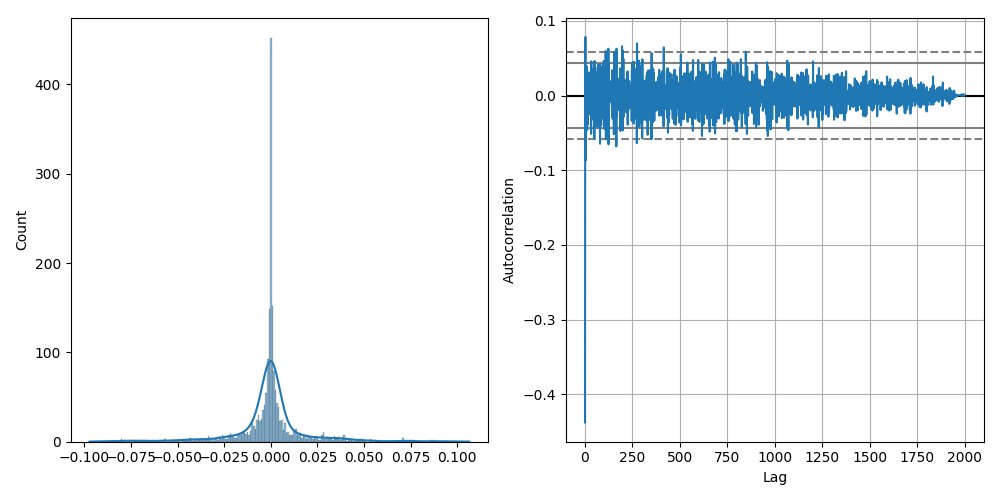

In [24]:
import copy
from spectral_denoising import test_for_white_noise
from pandas.plotting import autocorrelation_plot


def find_wavelet_threshold(signal,wavelet='sym8'):
    """
    This function is used to deterine what a good thresholding value is. It works by iterating
    through possible thresholding values until the noise component removed is found to be white
    noise.
    """

   # Create wavelet object and define parameters
    w = pywt.Wavelet(wavelet) 
    maxlev = pywt.dwt_max_level(len(signal), w.dec_len)
    print("maximum level is " + str(maxlev))
    threshold = 0.9 # Threshold for filtering coefficients as part of denoising, the higher this value the more coefficients you set to zero, ie more of the original signal you truncate away / denoise

    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(signal, w, level=maxlev) # multi-level decomposition

    # Threshold the wavelet coefficients for each scale / level, thereby removing noise.
    coeffs_thresholded = copy.deepcopy(coeffs)
    for i in range(1, len(coeffs)):
        coeffs_thresholded[i] = pywt.threshold(coeffs[i], threshold*np.max(coeffs[i]),mode='hard')

    # inverse transform coefficient to reconstruct time series signal, minus noise
    datarec = pywt.waverec(coeffs_thresholded, w) # multi-level decomposition reconstruction

    # noise component
    noise = signal - datarec

    # test if this component is white noise
    white_noise_1_0,percentage = test_for_white_noise(noise)

    # while thresholding has not removed a purely white noise component
    while white_noise_1_0 != True:
        # iterate on threshold value, this is a geometric iteration
        threshold = threshold*.9 

        # new thresholded signal
        coeffs_thresholded = copy.deepcopy(coeffs)
        for i in range(1, len(coeffs)):
            coeffs_thresholded[i] = pywt.threshold(coeffs[i], threshold*np.max(coeffs[i]),mode='hard')

        # inverse transform coefficient to reconstruct time series signal, minus noise
        datarec = pywt.waverec(coeffs_thresholded, w) # multi-level decomposition reconstruction
        noise = signal - datarec
        # is this removed component white noise?
        white_noise_1_0, percentage = test_for_white_noise(noise)

    # some white noise evidence
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    sns.histplot(np.real(noise),kde=True,ax=ax[0])
    autocorrelation_plot(noise,ax=ax[1])
    plt.tight_layout()

    return threshold

# test function
find_threshold(signal,wavelet='sym8')

In [ ]:
def automatic_wavelet_denoising_wf(signal,wavelet='sym8'):
    """
    This function is used for wavelet denoising an univariate time series signal
    during walk forward validation.

    params: signal: one dimensional time series signal. Preferably a numpy array.
    params: wavelet: mother wavelet to use for convolation / wavelet decomposition.
    """

    # step 1: Apply FFT and find threshold
    white_noise_threshold = find_wavelet_threshold(signal,wavelet='sym8')

    # step 2: Apply wavelet decomposition
    w = pywt.Wavelet(wavelet) 
    maxlev = pywt.dwt_max_level(len(signal), w.dec_len)
    print("maximum level is " + str(maxlev))
    threshold = 0.9 # Threshold for filtering coefficients as part of denoising, the higher this value the more coefficients you set to zero, ie more of the original signal you truncate away / denoise

    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(signal, w, level=maxlev) # multi-level decomposition

    # Threshold the wavelet coefficients for each scale / level, thereby removing noise.
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*np.max(coeffs[i]),mode='hard')

    # inverse transform coefficient to reconstruct time series signal, minus noise
    datarec = pywt.waverec(coeffs, w) # multi-level decomposition reconstruction

    return datarec